In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, median_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from scipy.stats import *
import h3
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from datetime import datetime
from math import floor
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn

In [2]:
ride_columns = ['accepted_driver_id', 'created_at', 'passenger_id', 'source_lat',
       'source_lng', 'destination_lat', 'destination_lng', 'eta', 'provider',
       'ata', 'id', 'city']

khatkesh_columns = ['ride_id','driver_id','a_t_a_result.arrival_a_t_a','a_t_a_result.boarding_a_t_a','a_t_a_result.ride_a_t_a','a_t_a_result.arrival_probe_result.probe.point.lat','a_t_a_result.arrival_probe_result.probe.point.lon','a_t_a_result.arrival_probe_result.probe.timestamp','a_t_a_result.arrival_probe_result.confidence','a_t_a_result.arrival_probe_result.h3_index', 'a_t_a_result.arrival_probe_result.k_ring_level','a_t_a_result.boarding_probe_result.probe.point.lat','a_t_a_result.boarding_probe_result.probe.point.lon','a_t_a_result.boarding_probe_result.probe.timestamp','a_t_a_result.boarding_probe_result.confidence','a_t_a_result.boarding_probe_result.h3_index','a_t_a_result.boarding_probe_result.k_ring_level','a_t_a_result.final_destination_probe_result.probe.point.lat','a_t_a_result.final_destination_probe_result.probe.point.lon','a_t_a_result.final_destination_probe_result.probe.timestamp','a_t_a_result.final_destination_probe_result.confidence','a_t_a_result.final_destination_probe_result.h3_index','a_t_a_result.final_destination_probe_result.k_ring_level','a_t_a_result.destination_probe_result.probe.point.lat','a_t_a_result.destination_probe_result.probe.point.lon','a_t_a_result.destination_probe_result.probe.timestamp','a_t_a_result.destination_probe_result.confidence','a_t_a_result.destination_probe_result.h3_index','a_t_a_result.destination_probe_result.k_ring_level','a_t_a_result.extra_destination_probe_result.probe.point.lat','a_t_a_result.extra_destination_probe_result.probe.point.lon','a_t_a_result.extra_destination_probe_result.probe.timestamp','a_t_a_result.extra_destination_probe_result.confidence','a_t_a_result.extra_destination_probe_result.h3_index','a_t_a_result.extra_destination_probe_result.k_ring_level','pickup_a_d_d_result.distance','pickup_a_d_d_result.confidence','pickup_a_d_d_result.route_ratio','pickup_a_d_d_result.g_p_s_ratio','ride_a_d_d_result.distance','ride_a_d_d_result.confidence','ride_a_d_d_result.route_ratio','ride_a_d_d_result.g_p_s_ratio','total_a_d_d_confidence','in_ride_allotment','e_d_d','clickhouse_time','hash']

train_dates = ['2022-08-02', '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-06', '2022-08-07', '2022-08-08',
               '2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12', '2022-08-13', '2022-08-14', '2022-08-15',
               '2022-08-16', '2022-08-17', '2022-08-18', '2022-08-19', '2022-08-20', '2022-08-21', '2022-08-22',
               '2022-08-23', '2022-08-24', '2022-08-25', '2022-08-26', '2022-08-27', '2022-08-28', '2022-08-29',
               '2022-08-30', '2022-08-31', '2022-09-01', '2022-09-02', '2022-09-03', '2022-09-04', '2022-09-05',
               '2022-09-06', '2022-09-07', '2022-09-08', '2022-09-09', '2022-09-10']

train_holidays = ['2022-08-07', '2022-08-08']

test_dates = ['2022-09-11', '2022-09-12', '2022-09-13', '2022-09-14', '2022-09-15', '2022-09-16', '2022-09-17',
              '2022-09-18', '2022-09-19', '2022-09-20', '2022-09-21', '2022-09-22', '2022-09-23', '2022-09-24',
              '2022-09-25', '2022-09-26', '2022-09-27', '2022-09-28', '2022-09-29', '2022-09-30', '2022-10-01',
              '2022-10-02', '2022-10-03', '2022-10-04', '2022-10-05', '2022-10-06', '2022-10-07', '2022-10-08',
              '2022-10-09']

test_holidays = ['2022-09-17', '2022-09-25', '2022-09-27', '2022-10-05']

In [3]:
rides_train = pd.read_csv('../rides_train.csv')
rides_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4063341 entries, 0 to 4063340
Data columns (total 59 columns):
 #   Column                                                       Dtype  
---  ------                                                       -----  
 0   accepted_driver_id                                           int64  
 1   created_at                                                   object 
 2   passenger_id                                                 int64  
 3   source_lat                                                   float64
 4   source_lng                                                   float64
 5   destination_lat                                              float64
 6   destination_lng                                              float64
 7   eta                                                          int64  
 8   provider                                                     object 
 9   ata                                                          int64  

In [4]:
rides_test = pd.read_csv('../rides_test.csv')
rides_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2729988 entries, 0 to 2729987
Data columns (total 59 columns):
 #   Column                                                       Dtype  
---  ------                                                       -----  
 0   accepted_driver_id                                           int64  
 1   created_at                                                   object 
 2   passenger_id                                                 int64  
 3   source_lat                                                   float64
 4   source_lng                                                   float64
 5   destination_lat                                              float64
 6   destination_lng                                              float64
 7   eta                                                          int64  
 8   provider                                                     object 
 9   ata                                                          int64  

In [9]:
rides_train[(abs(rides_train['eta'] - rides_train['a_t_a_result.ride_a_t_a']) > 1800) & (abs(rides_train['ata'] - rides_train['a_t_a_result.ride_a_t_a']) > 1800)]

,accepted_driver_id,created_at,passenger_id,source_lat,source_lng,destination_lat,destination_lng,eta,provider,ata,...,pickup_a_d_d_result.g_p_s_ratio,ride_a_d_d_result.distance,ride_a_d_d_result.confidence,ride_a_d_d_result.route_ratio,ride_a_d_d_result.g_p_s_ratio,total_a_d_d_confidence,in_ride_allotment,e_d_d,clickhouse_time,hash
163,3381644,2022-08-02 17:21:15,17292919,35.738861,51.488377,35.743332,51.571125,863,smapp-same-dc,845,...,0.000000,7.484460,0.000000,0.0,0.000000,0.000000,0.0,0.000000,2022-08-02 18:37:52,5528156935681518094
378,3663159,2022-08-02 17:16:42,1632623,35.799671,51.437275,35.808762,51.459133,610,smapp-same-dc,633,...,0.000000,2.215154,0.000000,0.0,0.000000,0.000000,0.0,0.000000,2022-08-02 18:37:52,2889677726077809410
723,3490903,2022-08-02 17:09:18,29694343,35.579037,51.486729,35.372143,51.612598,2356,smapp-same-dc,3790,...,0.000000,25.673012,0.000000,0.0,0.000000,0.000000,0.0,0.000000,2022-08-02 18:35:11,6528913712507247559
1745,2214114,2022-08-02 20:33:26,47320206,35.780285,51.375587,35.740623,51.823898,4140,smapp-same-dc,3752,...,0.001490,73.065002,0.671423,0.0,0.269747,0.689947,0.0,0.000000,2022-08-02 22:37:22,884179906846734231
1949,1257544,2022-08-02 15:46:39,32979623,35.640430,51.450829,35.732574,51.592113,1657,smapp-same-dc,2048,...,0.002342,47.762001,0.988945,0.0,0.555035,0.990500,0.0,0.000000,2022-08-02 17:03:33,16344145484622314507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4055819,301634,2022-09-10 16:28:22,5173366,35.717476,51.490105,35.752327,51.263584,2095,smapp-same-dc,2215,...,0.002169,55.514000,1.000000,0.0,0.993492,1.000000,0.0,26.069000,2022-09-10 18:05:34,2003657252863128950
4058408,3454779,2022-09-10 18:08:00,3409769,35.739578,51.472683,35.596123,51.445324,1652,smapp-same-dc,2906,...,0.000000,16.141077,0.000000,0.0,0.000000,0.000000,0.0,21.320000,2022-09-10 19:05:16,16253873571958063879
4058854,3489267,2022-09-10 11:11:39,26353053,35.742908,51.783337,35.817005,51.442070,2759,smapp-same-dc,2798,...,0.001880,63.567001,0.789474,0.0,0.313910,0.811543,0.0,41.224998,2022-09-10 12:41:46,5186798029532232596
4059897,95667,2022-09-10 16:59:54,2474904,35.797501,51.460590,35.704105,51.305275,2114,smapp-same-dc,1434,...,0.002342,53.491001,0.921286,0.0,0.793911,0.932501,0.0,23.295000,2022-09-10 18:17:29,3664452582758626753


In [5]:
rides_train_p1 = rides_train[(rides_train['eta'] < 1800) & (rides_train['eta'] >= 1200)]
rides_train_p1

,accepted_driver_id,created_at,passenger_id,source_lat,source_lng,destination_lat,destination_lng,eta,provider,ata,...,pickup_a_d_d_result.g_p_s_ratio,ride_a_d_d_result.distance,ride_a_d_d_result.confidence,ride_a_d_d_result.route_ratio,ride_a_d_d_result.g_p_s_ratio,total_a_d_d_confidence,in_ride_allotment,e_d_d,clickhouse_time,hash
4,1389231,2022-08-02 08:34:03,7470502,35.760803,51.412613,35.680412,51.406525,1295,smapp-same-dc,1320,...,0.007752,24.997999,1.000000,0.0,0.976744,1.000000,0.0,0.000,2022-08-02 09:01:23,16898267108648726188
7,2728438,2022-08-02 07:57:27,46320838,35.551586,51.251617,35.647949,51.399227,1721,smapp-same-dc,1726,...,0.006329,46.188000,1.000000,0.0,1.000000,1.000000,0.0,0.000,2022-08-02 08:29:58,10312041573682854014
8,3929597,2022-08-02 14:30:25,50000201,35.417717,51.795067,35.465965,51.675755,1230,smapp-same-dc,1048,...,0.009901,26.224001,0.950122,0.0,1.000000,0.957399,0.0,0.000,2022-08-02 14:52:35,5706011284955171486
14,1747330,2022-08-02 15:10:14,14512880,35.768822,51.305519,35.765411,51.442303,1641,smapp-same-dc,2785,...,0.003663,41.141998,1.000000,0.0,0.963370,1.000000,0.0,0.000,2022-08-02 16:09:17,8400418949954600245
17,3225425,2022-08-02 14:27:08,37976832,35.748501,51.373596,35.784950,51.459675,1419,smapp-same-dc,2136,...,0.004292,22.626093,0.769841,0.0,0.545064,0.810101,0.0,0.000,2022-08-02 15:15:30,6831010361265584132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4063317,3600338,2022-09-10 13:22:41,45600791,35.310020,51.730579,35.423836,51.585243,1565,smapp-same-dc,1638,...,0.006329,30.001736,0.768606,0.0,0.506329,0.734278,0.0,21.211,2022-09-10 13:57:58,13937156972589334868
4063318,721503,2022-09-10 02:05:49,18806359,35.719933,51.335495,35.727440,51.526875,1344,smapp-same-dc,1139,...,0.004975,24.430000,0.594638,0.0,0.079602,0.591892,0.0,22.188,2022-09-10 02:38:12,8941506555186050771
4063330,2547634,2022-09-10 14:17:31,18081143,35.720974,51.498474,35.708061,51.401943,1301,smapp-same-dc,1487,...,0.006944,20.761999,0.992727,0.0,0.937500,0.982424,0.0,10.682,2022-09-10 14:51:03,15050861885246709008
4063337,2368196,2022-09-10 15:42:45,5676377,35.724361,51.402294,35.794140,51.472240,1239,smapp-same-dc,1567,...,0.006452,33.134998,0.877245,0.0,0.748387,0.893184,0.0,14.393,2022-09-10 16:13:23,15480662044417010408


In [6]:
rides_test_p1 = rides_test[(rides_train['eta'] < 1800) & (rides_train['eta'] >= 1200)]
rides_test_p1

/var/folders/yq/707ysz_j3jlggmtk5clx13rm0000gn/T/ipykernel_57775/3561066352.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rides_test_p1 = rides_test[(rides_train['eta'] < 1800) & (rides_train['eta'] >= 1200)]


,accepted_driver_id,created_at,passenger_id,source_lat,source_lng,destination_lat,destination_lng,eta,provider,ata,...,pickup_a_d_d_result.g_p_s_ratio,ride_a_d_d_result.distance,ride_a_d_d_result.confidence,ride_a_d_d_result.route_ratio,ride_a_d_d_result.g_p_s_ratio,total_a_d_d_confidence,in_ride_allotment,e_d_d,clickhouse_time,hash
4,2255413,2022-09-11 16:18:50,13204345,35.754002,51.502956,35.633537,51.494732,1586,smapp-same-dc,1663,...,0.005952,29.419765,0.887584,0.0,0.779762,0.887654,0.000,17.757999,2022-09-11 18:07:01,3093743379629491928
7,747553,2022-09-11 08:41:48,32278185,35.686687,51.353626,35.676292,51.306538,661,smapp-same-dc,689,...,0.014085,7.608000,0.569532,0.0,0.112676,0.592628,0.000,6.406000,2022-09-11 09:00:15,14066967287691026815
8,178820,2022-09-11 08:47:42,47663548,35.737583,51.817417,35.716343,51.786205,767,smapp-same-dc,815,...,0.014286,14.842000,1.000000,0.0,0.985714,1.000000,0.000,7.461000,2022-09-11 09:05:35,2262467388776729805
14,995872,2022-09-11 10:37:12,28136537,35.792473,51.425320,35.698429,51.456745,1708,smapp-same-dc,2254,...,0.004484,31.429775,0.955925,0.0,0.959641,0.942513,0.412,19.094999,2022-09-11 11:21:00,6241151625673717460
17,3564404,2022-09-11 20:54:38,20882457,35.640404,51.416351,35.768814,51.276939,2944,smapp-same-dc,2778,...,0.003559,65.590630,0.834837,0.0,0.868327,0.857004,0.000,40.091000,2022-09-11 22:09:37,13862046135803300111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2729959,142695,2022-10-09 13:27:47,2630964,35.689465,51.463215,35.680313,51.469929,320,smapp-same-dc,302,...,0.000000,1.674000,0.500000,0.0,0.000000,0.500000,0.000,1.515000,2022-10-09 13:37:26,15103678060787255565
2729961,1009979,2022-10-09 13:29:46,20463806,35.735298,51.317776,35.680313,51.388023,1253,smapp-same-dc,1612,...,0.006289,28.757999,0.960011,0.0,0.911950,0.966451,0.000,14.957000,2022-10-09 14:02:58,16088522187439589912
2729964,2903607,2022-10-09 08:29:31,47375945,35.806316,51.475018,35.806435,51.449356,656,smapp-same-dc,913,...,0.011494,6.884000,1.000000,0.0,0.896552,1.000000,0.000,3.729000,2022-10-09 10:02:04,9571084981216949739
2729965,3391701,2022-10-09 15:26:58,25438077,35.757008,51.248936,35.755554,51.219669,496,smapp-same-dc,469,...,0.020833,7.808000,0.979124,0.0,0.791667,0.982049,0.000,4.083000,2022-10-09 15:38:52,5403978073619711955


There are some duplicates in the data

In [7]:
rides_train_p1 = rides_train_p1.drop_duplicates(subset=['ride_id', 'ata'])
len(rides_train_p1)

698924

In [8]:
rides_test_p1 = rides_test_p1.drop_duplicates(subset=['ride_id', 'ata'])
len(rides_test_p1)

467678

In [9]:
rides_train_p1 = rides_train_p1[(rides_train_p1['a_t_a_result.ride_a_t_a'] < 10800)]
rides_train_p1.describe()

,accepted_driver_id,passenger_id,source_lat,source_lng,destination_lat,destination_lng,eta,ata,ride_id,city,...,pickup_a_d_d_result.route_ratio,pickup_a_d_d_result.g_p_s_ratio,ride_a_d_d_result.distance,ride_a_d_d_result.confidence,ride_a_d_d_result.route_ratio,ride_a_d_d_result.g_p_s_ratio,total_a_d_d_confidence,in_ride_allotment,e_d_d,hash
count,6.982730e+05,6.982730e+05,698273.000000,698273.000000,698273.000000,698273.000000,698273.000000,698273.000000,6.982730e+05,698273.0,...,698273.000000,698273.000000,698273.000000,698273.000000,698273.000000,698273.000000,698273.000000,698273.000000,698273.000000,6.982730e+05
mean,1.857425e+06,2.168748e+07,35.710892,51.399349,35.712309,51.395568,1456.448922,1725.063978,4.824418e+09,1.0,...,0.000156,0.005586,26.897149,0.854432,0.000019,0.719289,0.863478,0.074900,3.885671,9.220944e+18
std,1.409676e+06,1.787583e+07,0.074141,0.100507,0.073240,0.106259,169.848034,575.790389,6.012160e+07,0.0,...,0.009760,0.002384,10.485326,0.172798,0.000484,0.333527,0.164499,0.608508,7.312144,5.324659e+18
min,9.000000e+00,7.600000e+01,35.178387,50.901024,35.173473,50.764294,1200.000000,124.000000,4.714480e+09,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.692488e+13
25%,4.473740e+05,3.664565e+06,35.681526,51.349072,35.685211,51.349880,1308.000000,1386.000000,4.774177e+09,1.0,...,0.000000,0.004717,19.203861,0.756829,0.000000,0.500000,0.781659,0.000000,0.000000,4.613067e+18
50%,1.746312e+06,2.015608e+07,35.723850,51.407139,35.724022,51.408184,1436.000000,1624.000000,4.825935e+09,1.0,...,0.000000,0.005882,25.814985,0.937934,0.000000,0.893443,0.940534,0.000000,0.000000,9.214285e+18
75%,3.138573e+06,3.603966e+07,35.759724,51.453903,35.760132,51.449703,1594.000000,1930.000000,4.872342e+09,1.0,...,0.000000,0.006993,33.271999,0.987221,0.000000,0.979310,0.987554,0.000000,0.000000,1.383868e+19
max,4.330757e+06,5.737754e+07,35.839870,52.107700,35.943981,52.106018,1799.000000,20274.000000,4.933870e+09,1.0,...,1.000000,0.500000,1042.181519,1.000000,0.072162,1.000000,1.000000,84.599289,69.930000,1.844674e+19


In [10]:
rides_train_p1 = rides_train_p1[(rides_train_p1['a_t_a_result.destination_probe_result.confidence'] > 0) & (rides_train_p1['a_t_a_result.boarding_probe_result.confidence'] > 0)]
rides_train_p1.describe()

,accepted_driver_id,passenger_id,source_lat,source_lng,destination_lat,destination_lng,eta,ata,ride_id,city,...,pickup_a_d_d_result.route_ratio,pickup_a_d_d_result.g_p_s_ratio,ride_a_d_d_result.distance,ride_a_d_d_result.confidence,ride_a_d_d_result.route_ratio,ride_a_d_d_result.g_p_s_ratio,total_a_d_d_confidence,in_ride_allotment,e_d_d,hash
count,4.186150e+05,4.186150e+05,418615.000000,418615.000000,418615.000000,418615.000000,418615.000000,418615.000000,4.186150e+05,418615.0,...,418615.000000,418615.000000,418615.000000,418615.000000,418615.000000,418615.000000,418615.000000,418615.000000,418615.000000,4.186150e+05
mean,1.903595e+06,2.147731e+07,35.711474,51.399069,35.713951,51.395514,1455.527726,1748.031867,4.824397e+09,1.0,...,0.000076,0.006219,28.394249,0.904064,0.000011,0.826222,0.913169,0.081312,3.960818,9.213934e+18
std,1.419568e+06,1.783545e+07,0.073310,0.100062,0.072303,0.106199,169.782330,567.417564,6.024950e+07,0.0,...,0.006515,0.001722,10.024591,0.137932,0.000339,0.255498,0.123153,0.623836,7.372828,5.324953e+18
min,9.000000e+00,7.600000e+01,35.178387,50.901024,35.173473,50.764294,1200.000000,143.000000,4.714480e+09,1.0,...,0.000000,0.000904,0.000000,0.000000,0.000000,0.003937,0.000000,0.000000,0.000000,7.692488e+13
25%,4.738330e+05,3.543161e+06,35.681633,51.348881,35.686920,51.350353,1307.000000,1412.000000,4.773912e+09,1.0,...,0.000000,0.005208,21.094000,0.883405,0.000000,0.784946,0.890993,0.000000,0.000000,4.606591e+18
50%,1.824698e+06,1.978329e+07,35.724007,51.406883,35.725761,51.407803,1435.000000,1646.000000,4.825453e+09,1.0,...,0.000000,0.006135,27.466999,0.964323,0.000000,0.948617,0.965939,0.000000,0.000000,9.200861e+18
75%,3.207710e+06,3.578205e+07,35.759916,51.453754,35.761288,51.450859,1592.000000,1950.000000,4.872820e+09,1.0,...,0.000000,0.007143,34.560001,0.994926,0.000000,0.992308,0.994692,0.000000,0.000000,1.383483e+19
max,4.330757e+06,5.737754e+07,35.839024,52.107700,35.943981,52.103642,1799.000000,20274.000000,4.933870e+09,1.0,...,1.000000,0.500000,260.281769,1.000000,0.048962,1.000000,1.000000,22.429001,66.652000,1.844674e+19


In [11]:
rides_test_p1 = rides_test_p1[(rides_test_p1['a_t_a_result.destination_probe_result.confidence'] > 0) & (rides_test_p1['a_t_a_result.boarding_probe_result.confidence'] > 0)]
rides_test_p1.describe()

,accepted_driver_id,passenger_id,source_lat,source_lng,destination_lat,destination_lng,eta,ata,ride_id,city,...,pickup_a_d_d_result.route_ratio,pickup_a_d_d_result.g_p_s_ratio,ride_a_d_d_result.distance,ride_a_d_d_result.confidence,ride_a_d_d_result.route_ratio,ride_a_d_d_result.g_p_s_ratio,total_a_d_d_confidence,in_ride_allotment,e_d_d,hash
count,2.881490e+05,2.881490e+05,288149.000000,288149.000000,288149.000000,288149.000000,288149.000000,288149.000000,2.881490e+05,288149.0,...,288149.000000,288149.000000,288149.000000,288149.000000,288149.000000,288149.000000,288149.000000,288149.000000,288149.000000,2.881490e+05
mean,1.967032e+06,2.346865e+07,35.695922,51.403784,35.698728,51.395736,985.687027,1180.564059,5.011295e+09,1.0,...,0.000062,0.015431,19.486701,0.927463,0.000026,0.866547,0.933955,0.023619,11.144522,9.205157e+18
std,1.464824e+06,1.813843e+07,0.091833,0.135358,0.092653,0.147434,720.668197,1009.135740,4.389831e+07,0.0,...,0.005613,0.015654,19.502212,0.131347,0.001119,0.233325,0.115441,0.223795,11.706380,5.323730e+18
min,9.000000e+00,3.800000e+01,35.204285,50.900341,34.102810,49.580978,1.000000,120.000000,4.933927e+09,1.0,...,0.000000,0.000514,0.000000,0.000000,0.000000,0.003425,0.000000,0.000000,0.174000,1.492987e+13
25%,4.810610e+05,4.669793e+06,35.666069,51.337864,35.669971,51.335136,478.000000,525.000000,4.973610e+09,1.0,...,0.000000,0.006757,6.496000,0.923397,0.000000,0.861111,0.920487,0.000000,3.638000,4.586824e+18
50%,1.895929e+06,2.338855e+07,35.721897,51.407692,35.723518,51.406719,803.000000,901.000000,5.012743e+09,1.0,...,0.000000,0.011236,13.736000,0.993789,0.000000,0.977612,0.990108,0.000000,7.750000,9.188908e+18
75%,3.312968e+06,3.805059e+07,35.754482,51.464634,35.756237,51.462963,1279.000000,1503.000000,5.049485e+09,1.0,...,0.000000,0.019231,25.582104,1.000000,0.000000,1.000000,1.000000,0.000000,14.273000,1.381175e+19
max,4.422331e+06,5.813857e+07,35.839817,52.805283,37.294868,53.395916,13406.000000,19435.000000,5.083661e+09,1.0,...,1.000000,1.000000,727.451294,1.000000,0.157182,1.000000,1.000000,21.841000,325.363007,1.844674e+19


In [12]:
rides_with_id = rides_train_p1

In [13]:
rides_train_p1 = rides_train_p1[['eta', 'ata', 'a_t_a_result.ride_a_t_a', 'created_at', 'source_lat', 'source_lng', 'destination_lat', 'destination_lng', 'e_d_d', 'clickhouse_time']]
rides_train_p1

,eta,ata,a_t_a_result.ride_a_t_a,created_at,source_lat,source_lng,destination_lat,destination_lng,e_d_d,clickhouse_time
4,1295,1320,1288,2022-08-02 08:34:03,35.760803,51.412613,35.680412,51.406525,0.000,2022-08-02 09:01:23
7,1721,1726,1580,2022-08-02 07:57:27,35.551586,51.251617,35.647949,51.399227,0.000,2022-08-02 08:29:58
8,1230,1048,1004,2022-08-02 14:30:25,35.417717,51.795067,35.465965,51.675755,0.000,2022-08-02 14:52:35
14,1641,2785,2727,2022-08-02 15:10:14,35.768822,51.305519,35.765411,51.442303,0.000,2022-08-02 16:09:17
18,1390,2010,1964,2022-08-02 11:08:50,35.730118,51.382473,35.758369,51.441551,0.000,2022-08-02 12:05:23
...,...,...,...,...,...,...,...,...,...,...
4063264,1712,1875,1830,2022-09-10 12:24:51,35.669792,51.302319,35.685867,51.414448,13.342,2022-09-10 13:04:13
4063317,1565,1638,1579,2022-09-10 13:22:41,35.310020,51.730579,35.423836,51.585243,21.211,2022-09-10 13:57:58
4063330,1301,1487,1435,2022-09-10 14:17:31,35.720974,51.498474,35.708061,51.401943,10.682,2022-09-10 14:51:03
4063337,1239,1567,1544,2022-09-10 15:42:45,35.724361,51.402294,35.794140,51.472240,14.393,2022-09-10 16:13:23


In [14]:
rides_test_p1 = rides_test_p1[['eta', 'ata', 'a_t_a_result.ride_a_t_a', 'created_at', 'source_lat', 'source_lng', 'destination_lat', 'destination_lng', 'e_d_d', 'clickhouse_time']]
rides_test_p1

,eta,ata,a_t_a_result.ride_a_t_a,created_at,source_lat,source_lng,destination_lat,destination_lng,e_d_d,clickhouse_time
4,1586,1663,1672,2022-09-11 16:18:50,35.754002,51.502956,35.633537,51.494732,17.757999,2022-09-11 18:07:01
8,767,815,696,2022-09-11 08:47:42,35.737583,51.817417,35.716343,51.786205,7.461000,2022-09-11 09:05:35
14,1708,2254,2224,2022-09-11 10:37:12,35.792473,51.425320,35.698429,51.456745,19.094999,2022-09-11 11:21:00
18,1092,1224,1401,2022-09-11 15:37:23,35.799767,51.500786,35.817673,51.438400,7.260000,2022-09-11 16:16:49
20,2472,2877,2762,2022-09-11 07:07:26,35.356205,51.641312,35.601074,51.435585,38.662998,2022-09-11 08:02:38
...,...,...,...,...,...,...,...,...,...,...
2729940,493,571,636,2022-10-09 19:41:26,35.703400,51.322357,35.704979,51.331409,3.440000,2022-10-09 19:57:58
2729944,491,455,424,2022-10-09 14:13:09,35.732574,51.920444,35.733791,51.895199,4.697000,2022-10-09 14:29:09
2729945,467,916,908,2022-10-09 12:31:56,35.780022,51.311806,35.775215,51.330162,7.538000,2022-10-09 12:54:54
2729949,877,1003,975,2022-10-09 12:34:24,35.731308,51.440887,35.792816,51.489731,10.590000,2022-10-09 12:56:15


In [15]:
# rides_train_p1['source_h3_4'] = rides_train_p1.apply(lambda row: h3.geo_to_h3(row.source_lat, row.source_lng, 4), axis=1)
# rides_train_p1['dest_h3_4'] = rides_train_p1.apply(lambda row: h3.geo_to_h3(row.destination_lat, row.destination_lng, 4), axis=1)
rides_train_p1['hour'] = rides_train_p1.apply(lambda row: ((datetime.timestamp(datetime.strptime(row.created_at,"%Y-%m-%d %H:%M:%S")) - 1662147000) % 604800) / 3600, axis=1)
rides_train_p1['holiday'] = rides_train_p1.apply(lambda row: int(row.created_at.split()[0] in train_holidays), axis=1)
rides_train_p1

/var/folders/yq/707ysz_j3jlggmtk5clx13rm0000gn/T/ipykernel_57775/1174177227.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rides_train_p1['hour'] = rides_train_p1.apply(lambda row: ((datetime.timestamp(datetime.strptime(row.created_at,"%Y-%m-%d %H:%M:%S")) - 1662147000) % 604800) / 3600, axis=1)
/var/folders/yq/707ysz_j3jlggmtk5clx13rm0000gn/T/ipykernel_57775/1174177227.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rides_train_p1['holiday'] = rides_train_p1.apply(lambda row: int(row.created_at.sp

,eta,ata,a_t_a_result.ride_a_t_a,created_at,source_lat,source_lng,destination_lat,destination_lng,e_d_d,clickhouse_time,hour,holiday
4,1295,1320,1288,2022-08-02 08:34:03,35.760803,51.412613,35.680412,51.406525,0.000,2022-08-02 09:01:23,80.567500,0
7,1721,1726,1580,2022-08-02 07:57:27,35.551586,51.251617,35.647949,51.399227,0.000,2022-08-02 08:29:58,79.957500,0
8,1230,1048,1004,2022-08-02 14:30:25,35.417717,51.795067,35.465965,51.675755,0.000,2022-08-02 14:52:35,86.506944,0
14,1641,2785,2727,2022-08-02 15:10:14,35.768822,51.305519,35.765411,51.442303,0.000,2022-08-02 16:09:17,87.170556,0
18,1390,2010,1964,2022-08-02 11:08:50,35.730118,51.382473,35.758369,51.441551,0.000,2022-08-02 12:05:23,83.147222,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4063264,1712,1875,1830,2022-09-10 12:24:51,35.669792,51.302319,35.685867,51.414448,13.342,2022-09-10 13:04:13,12.414167,0
4063317,1565,1638,1579,2022-09-10 13:22:41,35.310020,51.730579,35.423836,51.585243,21.211,2022-09-10 13:57:58,13.378056,0
4063330,1301,1487,1435,2022-09-10 14:17:31,35.720974,51.498474,35.708061,51.401943,10.682,2022-09-10 14:51:03,14.291944,0
4063337,1239,1567,1544,2022-09-10 15:42:45,35.724361,51.402294,35.794140,51.472240,14.393,2022-09-10 16:13:23,15.712500,0


In [16]:
# rides_test_p1['source_h3_4'] = rides_test_p1.apply(lambda row: h3.geo_to_h3(row.source_lat, row.source_lng, 4), axis=1)
# rides_test_p1['dest_h3_4'] = rides_test_p1.apply(lambda row: h3.geo_to_h3(row.destination_lat, row.destination_lng, 4), axis=1)
rides_test_p1['hour'] = rides_test_p1.apply(lambda row: ((datetime.timestamp(datetime.strptime(row.created_at,"%Y-%m-%d %H:%M:%S")) - 1662147000) % 604800) / 3600, axis=1)
rides_test_p1['holiday'] = rides_test_p1.apply(lambda row: int(row.created_at.split()[0] in test_holidays), axis=1)
rides_test_p1

,eta,ata,a_t_a_result.ride_a_t_a,created_at,source_lat,source_lng,destination_lat,destination_lng,e_d_d,clickhouse_time,hour,holiday
4,1586,1663,1672,2022-09-11 16:18:50,35.754002,51.502956,35.633537,51.494732,17.757999,2022-09-11 18:07:01,40.313889,0
8,767,815,696,2022-09-11 08:47:42,35.737583,51.817417,35.716343,51.786205,7.461000,2022-09-11 09:05:35,32.795000,0
14,1708,2254,2224,2022-09-11 10:37:12,35.792473,51.425320,35.698429,51.456745,19.094999,2022-09-11 11:21:00,34.620000,0
18,1092,1224,1401,2022-09-11 15:37:23,35.799767,51.500786,35.817673,51.438400,7.260000,2022-09-11 16:16:49,39.623056,0
20,2472,2877,2762,2022-09-11 07:07:26,35.356205,51.641312,35.601074,51.435585,38.662998,2022-09-11 08:02:38,31.123889,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2729940,493,571,636,2022-10-09 19:41:26,35.703400,51.322357,35.704979,51.331409,3.440000,2022-10-09 19:57:58,44.690556,0
2729944,491,455,424,2022-10-09 14:13:09,35.732574,51.920444,35.733791,51.895199,4.697000,2022-10-09 14:29:09,39.219167,0
2729945,467,916,908,2022-10-09 12:31:56,35.780022,51.311806,35.775215,51.330162,7.538000,2022-10-09 12:54:54,37.532222,0
2729949,877,1003,975,2022-10-09 12:34:24,35.731308,51.440887,35.792816,51.489731,10.590000,2022-10-09 12:56:15,37.573333,0


In [17]:
train_p1_geo_x = rides_train_p1[["eta", "source_lat", "source_lng", "destination_lat", "destination_lng", "hour", "holiday"]]
# train_p1_h3_x = rides_train_p1[["eta", "source_h3_4", "dest_h3_4", "hour", "holiday"]]
train_p1_geo_y = rides_train_p1["a_t_a_result.ride_a_t_a"]
# train_p1_h3_y = rides_train_p1["a_t_a_result.ride_a_t_a"]

In [18]:
test_p1_geo_x = rides_test_p1[["eta", "source_lat", "source_lng", "destination_lat", "destination_lng", "hour", "holiday"]]
# test_p1_h3_x = rides_test_p1[["eta", "source_h3_4", "dest_h3_4", "hour", "holiday"]]
test_p1_geo_y = rides_test_p1["a_t_a_result.ride_a_t_a"]
# test_p1_h3_y = rides_test_p1["a_t_a_result.ride_a_t_a"]

In [19]:
# dummy_train_rides = pd.get_dummies(train_p1_h3_x, prefix={'source_h3_4':'source_h3_4',
#                                                              'dest_h3_4':'dest_h3_4'})
# dummy_train_rides.describe()

In [20]:
# print(np.count_nonzero(dummy_train_rides, axis=0))
# print(dummy_train_rides.columns)

In [21]:
# geo_noise = np.count_nonzero(dummy_train_rides, axis=0) < 100
#
# cols = dummy_train_rides.columns
# for col, noise in zip(cols, geo_noise):
#     if noise:
#         # DOESN'T REINDEX
#         # remove the rows where rides_train_p1_x is in the noisy geo (geo is 1)
#         train_p1_h3_x = train_p1_h3_x[dummy_train_rides[col] == 0]
#         train_p1_h3_y = train_p1_h3_y[dummy_train_rides[col] == 0]
#
# train_p1_h3_x.describe()

In [22]:
# ohe = ColumnTransformer(
#     [('OHE', OneHotEncoder(handle_unknown='ignore', sparse=False),['source_h3_4', 'dest_h3_4'])],
#     remainder = 'passthrough'
#     ).fit(train_p1_h3_x)

In [23]:
# ohe.get_feature_names_out()

In [24]:
# train_p1_h3_x = ohe.transform(train_p1_h3_x)

In [25]:
# test_p1_h3_x = ohe.transform(test_p1_h3_x)

In [50]:
rational_index = abs(train_p1_geo_x['eta'] - train_p1_geo_y) < 1800

In [51]:
train_p1_geo_x = train_p1_geo_x[rational_index]
train_p1_geo_y = train_p1_geo_y[rational_index]

In [52]:
test_rational_index = abs(test_p1_geo_x['eta'] - test_p1_geo_y) < 1800
test_p1_geo_x = test_p1_geo_x[test_rational_index]
test_p1_geo_y = test_p1_geo_y[test_rational_index]

In [53]:
train_eta = train_p1_geo_x['eta']
test_eta = test_p1_geo_x['eta']

# train_p1_geo_x = train_p1_geo_x[["source_lat", "source_lng", "destination_lat", "destination_lng", "hour", "holiday"]]
# test_p1_geo_x = test_p1_geo_x[["source_lat", "source_lng", "destination_lat", "destination_lng", "hour", "holiday"]]

In [54]:
reg_geo_p1 = LinearRegression().fit(train_p1_geo_x, train_p1_geo_y)

In [55]:
print(reg_geo_p1.coef_)
print(reg_geo_p1.intercept_)

[  1.19995579  60.52077663  19.45155019 429.49508629  84.08659027
  -0.43249748 -77.01206346]
-22844.89730651855


In [56]:
train_pred_geo = reg_geo_p1.predict(train_p1_geo_x)
test_pred_geo = reg_geo_p1.predict(test_p1_geo_x)

In [57]:
print("ETA train MAE", mean_absolute_error(train_p1_geo_y, train_eta))
print("prediction train MAE", mean_absolute_error(train_p1_geo_y, train_pred_geo))

print("ETA test MAE ", mean_absolute_error(test_p1_geo_y, test_eta))
print("prediction test MAE", mean_absolute_error(test_p1_geo_y, test_pred_geo))


print("ETA train MSE", mean_squared_error(train_p1_geo_y, train_eta))
print("prediction train MSE", mean_squared_error(train_p1_geo_y, train_pred_geo))

print("ETA test MSE ", mean_squared_error(test_p1_geo_y, test_eta))
print("prediction test MSE", mean_squared_error(test_p1_geo_y, test_pred_geo))


print("ETA train explained_variance_score", explained_variance_score(train_p1_geo_y, train_eta))
print("prediction train explained_variance_score", explained_variance_score(train_p1_geo_y, train_pred_geo))

print("ETA test explained_variance_score ", explained_variance_score(test_p1_geo_y, test_eta))
print("prediction test explained_variance_score", explained_variance_score(test_p1_geo_y, test_pred_geo))


print("ETA train median_absolute_error", median_absolute_error(train_p1_geo_y, train_eta))
print("prediction train median_absolute_error", median_absolute_error(train_p1_geo_y, train_pred_geo))

print("ETA test median_absolute_error ", median_absolute_error(test_p1_geo_y, test_eta))
print("prediction test median_absolute_error", median_absolute_error(test_p1_geo_y, test_pred_geo))


print("ETA train r2_score", r2_score(train_p1_geo_y, train_eta))
print("prediction train r2_score", r2_score(train_p1_geo_y, train_pred_geo))

print("ETA test r2_score ", r2_score(test_p1_geo_y, test_eta))
print("prediction test r2_score", r2_score(test_p1_geo_y, test_pred_geo))


print("ETA train MAPE", mean_absolute_percentage_error(train_p1_geo_y, train_eta))
print("prediction train MAPE", mean_absolute_percentage_error(train_p1_geo_y, train_pred_geo))

print("ETA test MAPE ", mean_absolute_percentage_error(test_p1_geo_y, test_eta))
print("prediction test MAPE", mean_absolute_percentage_error(test_p1_geo_y, test_pred_geo))

ETA train MAE 303.05601677797216
prediction train MAE 270.0441347116858
ETA test MAE  198.93715245801377
prediction test MAE 197.72842098826686
ETA train MSE 186311.40376344605
prediction train MSE 130232.03449502192
ETA test MSE  109690.4659505515
prediction test MSE 86595.15998340784
ETA train explained_variance_score 0.22988020895077965
prediction train explained_variance_score 0.24686168720432022
ETA test explained_variance_score  0.8693451809315293
prediction test explained_variance_score 0.8768978838276482
ETA train median_absolute_error 202.0
prediction train median_absolute_error 211.7969343737459
ETA test median_absolute_error  103.0
prediction test median_absolute_error 130.12398476009366
ETA train r2_score -0.07744808586523355
prediction train r2_score 0.2468616872043201
ETA test r2_score  0.8438239267452461
prediction test r2_score 0.8767067681600286
ETA train MAPE 0.1617958423506161
prediction train MAPE 0.1630260834281298
ETA test MAPE  0.18084430516321362
prediction test

In [58]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=50)
neigh.fit(train_p1_geo_x, train_p1_geo_y)

KNeighborsRegressor(n_neighbors=50)

In [59]:
train_knn_pred_geo = neigh.predict(train_p1_geo_x)

In [60]:
test_knn_pred_geo = neigh.predict(test_p1_geo_x)

In [61]:
print("ETA train MAE", mean_absolute_error(train_p1_geo_y, train_eta))
print("prediction train MAE", mean_absolute_error(train_p1_geo_y, train_knn_pred_geo))

print("ETA test MAE ", mean_absolute_error(test_p1_geo_y, test_eta))
print("prediction test MAE", mean_absolute_error(test_p1_geo_y, test_knn_pred_geo))


print("ETA train MSE", mean_squared_error(train_p1_geo_y, train_eta))
print("prediction train MSE", mean_squared_error(train_p1_geo_y, train_knn_pred_geo))

print("ETA test MSE ", mean_squared_error(test_p1_geo_y, test_eta))
print("prediction test MSE", mean_squared_error(test_p1_geo_y, test_knn_pred_geo))


print("ETA train explained_variance_score", explained_variance_score(train_p1_geo_y, train_eta))
print("prediction train explained_variance_score", explained_variance_score(train_p1_geo_y, train_knn_pred_geo))

print("ETA test explained_variance_score ", explained_variance_score(test_p1_geo_y, test_eta))
print("prediction test explained_variance_score", explained_variance_score(test_p1_geo_y, test_knn_pred_geo))


print("ETA train median_absolute_error", median_absolute_error(train_p1_geo_y, train_eta))
print("prediction train median_absolute_error", median_absolute_error(train_p1_geo_y, train_knn_pred_geo))

print("ETA test median_absolute_error ", median_absolute_error(test_p1_geo_y, test_eta))
print("prediction test median_absolute_error", median_absolute_error(test_p1_geo_y, test_knn_pred_geo))


print("ETA train r2_score", r2_score(train_p1_geo_y, train_eta))
print("prediction train r2_score", r2_score(train_p1_geo_y, train_knn_pred_geo))

print("ETA test r2_score ", r2_score(test_p1_geo_y, test_eta))
print("prediction test r2_score", r2_score(test_p1_geo_y, test_knn_pred_geo))


print("ETA train MAPE", mean_absolute_percentage_error(train_p1_geo_y, train_eta))
print("prediction train MAPE", mean_absolute_percentage_error(train_p1_geo_y, train_knn_pred_geo))

print("ETA test MAPE ", mean_absolute_percentage_error(test_p1_geo_y, test_eta))
print("prediction test MAPE", mean_absolute_percentage_error(test_p1_geo_y, test_knn_pred_geo))

ETA train MAE 303.05601677797216
prediction train MAE 248.65587185533832
ETA test MAE  198.93715245801377
prediction test MAE 647.6301651329711
ETA train MSE 186311.40376344605
prediction train MSE 110606.5244008862
ETA test MSE  109690.4659505515
prediction test MSE 608931.0242283179
ETA train explained_variance_score 0.22988020895077965
prediction train explained_variance_score 0.3603903523829256
ETA test explained_variance_score  0.8693451809315293
prediction test explained_variance_score 0.3848412842899378
ETA train median_absolute_error 202.0
prediction train median_absolute_error 194.1199999999999
ETA test median_absolute_error  103.0
prediction test median_absolute_error 628.02
ETA train r2_score -0.07744808586523355
prediction train r2_score 0.36035698517278536
ETA test r2_score  0.8438239267452461
prediction test r2_score 0.13301073686891396
ETA train MAPE 0.1617958423506161
prediction train MAPE 0.14968560751150273
ETA test MAPE  0.18084430516321362
prediction test MAPE 1.344

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
regr.fit(train_p1_geo_x, train_p1_geo_y)

In [ ]:
train_svm_pred_geo = regr.predict(train_p1_geo_x)
test_svm_pred_geo = regr.predict(test_p1_geo_x)

In [ ]:
print("ETA train MAE", mean_absolute_error(train_p1_geo_y, train_eta))
print("prediction train MAE", mean_absolute_error(train_p1_geo_y, train_svm_pred_geo))

print("ETA test MAE ", mean_absolute_error(test_p1_geo_y, test_eta))
print("prediction test MAE", mean_absolute_error(test_p1_geo_y, test_svm_pred_geo))


print("ETA train MSE", mean_squared_error(train_p1_geo_y, train_eta))
print("prediction train MSE", mean_squared_error(train_p1_geo_y, train_svm_pred_geo))

print("ETA test MSE ", mean_squared_error(test_p1_geo_y, test_eta))
print("prediction test MSE", mean_squared_error(test_p1_geo_y, test_svm_pred_geo))


print("ETA train explained_variance_score", explained_variance_score(train_p1_geo_y, train_eta))
print("prediction train explained_variance_score", explained_variance_score(train_p1_geo_y, train_svm_pred_geo))

print("ETA test explained_variance_score ", explained_variance_score(test_p1_geo_y, test_eta))
print("prediction test explained_variance_score", explained_variance_score(test_p1_geo_y, test_svm_pred_geo))


print("ETA train median_absolute_error", median_absolute_error(train_p1_geo_y, train_eta))
print("prediction train median_absolute_error", median_absolute_error(train_p1_geo_y, train_svm_pred_geo))

print("ETA test median_absolute_error ", median_absolute_error(test_p1_geo_y, test_eta))
print("prediction test median_absolute_error", median_absolute_error(test_p1_geo_y, test_svm_pred_geo))


print("ETA train r2_score", r2_score(train_p1_geo_y, train_eta))
print("prediction train r2_score", r2_score(train_p1_geo_y, train_svm_pred_geo))

print("ETA test r2_score ", r2_score(test_p1_geo_y, test_eta))
print("prediction test r2_score", r2_score(test_p1_geo_y, test_svm_pred_geo))


print("ETA train MAPE", mean_absolute_percentage_error(train_p1_geo_y, train_eta))
print("prediction train MAPE", mean_absolute_percentage_error(train_p1_geo_y, train_svm_pred_geo))

print("ETA test MAPE ", mean_absolute_percentage_error(test_p1_geo_y, test_eta))
print("prediction test MAPE", mean_absolute_percentage_error(test_p1_geo_y, test_svm_pred_geo))

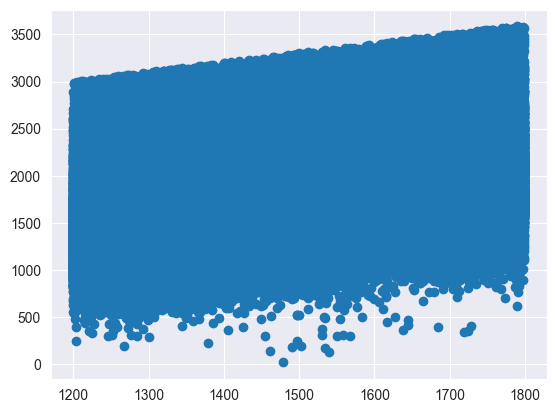

In [62]:
plt.scatter(train_eta, train_p1_geo_y)

In [63]:
import seaborn as sns

<AxesSubplot: ylabel='Count'>

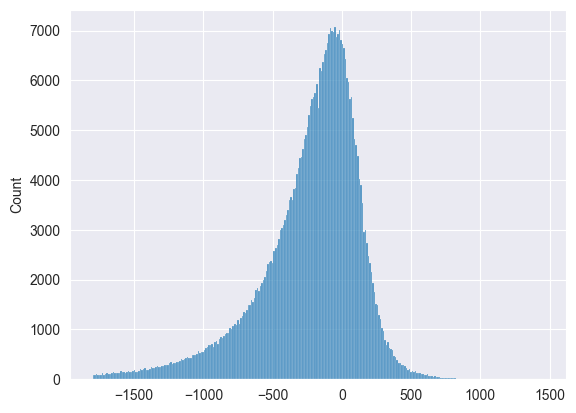

In [64]:
eta_err = train_p1_geo_x['eta'] - train_p1_geo_y
sns.histplot(eta_err)

In [65]:
print(eta_err.mean())
print(eta_err.std())
print(eta_err.kurtosis())
print(eta_err.skew())

-230.52753964955687
364.9229767864145
1.959038628268726
-1.1453677343051023


<AxesSubplot: xlabel='a_t_a_result.ride_a_t_a', ylabel='Count'>

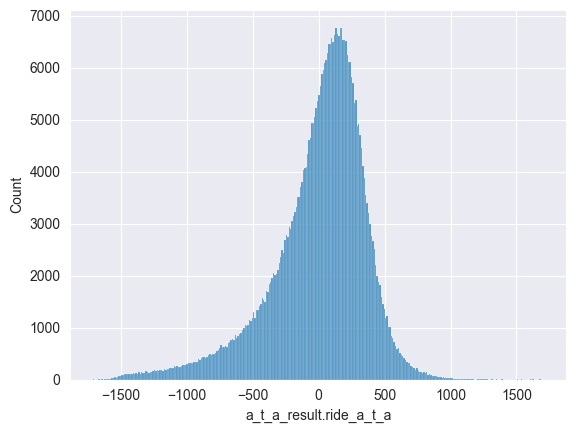

In [66]:
pred_err = train_pred_geo - train_p1_geo_y
sns.histplot(pred_err)

In [67]:
print(pred_err.mean())
print(pred_err.std())
print(pred_err.kurtosis())
print(pred_err.skew())

-7.815383634135306e-13
360.8771940150293
1.8983215137755232
-1.0628900359362234


In [154]:
reg_h3_p1 = LinearRegression().fit(train_p1_h3_x, train_p1_h3_y)

In [155]:
print(reg_h3_p1.coef_)
print(reg_h3_p1.intercept_)

[ 1.26783627e+10  1.26783627e+10  3.36497938e+11  1.26783627e+10
  1.26783627e+10  1.26783627e+10  1.26783627e+10  1.26783627e+10
 -2.61619424e+09 -2.61619425e+09 -3.26435770e+11 -2.61619425e+09
 -2.61619425e+09 -2.61619425e+09 -2.61619424e+09 -2.61619425e+09
  9.86321442e-01 -2.57691789e-02  8.68180725e+00]
-10062168381.208202


In [156]:
train_pred_h3 = reg_h3_p1.predict(train_p1_h3_x)
test_pred_h3 = reg_h3_p1.predict(test_p1_h3_x)

In [157]:
known_h3_index = np.count_nonzero(test_p1_h3_x[:, 0:17], axis=1) == 2

In [158]:
test_p1_h3_y = test_p1_h3_y[known_h3_index]
test_p1_h3_x = test_p1_h3_x[known_h3_index]
test_pred_h3 = test_pred_h3[known_h3_index]

In [45]:
d = {'eta': train_p1_geo_x['eta'], 'seldon': train_pred_geo, 'ata': train_p1_geo_y, 'eta - ata': train_p1_geo_x['eta'] - train_p1_geo_y, 'seldon - ata': train_pred_geo - train_p1_geo_y}
df = pd.DataFrame(data=d)
df[abs(df['eta - ata']) > 2200]

,eta,seldon,ata,eta - ata,seldon - ata
2976,1526,1836.110116,4156,-2630,-2319.889884
3358,1678,2006.297146,3904,-2226,-1897.702854
4773,1331,1572.528030,3843,-2512,-2270.471970
6554,1668,1976.782710,4060,-2392,-2083.217290
8386,1334,1450.304367,3802,-2468,-2351.695633
...,...,...,...,...,...
4042946,1750,2124.569817,4674,-2924,-2549.430183
4044773,1773,2162.366582,4176,-2403,-2013.633418
4049608,1626,1969.847027,4132,-2506,-2162.152973
4051682,1641,2036.224360,5930,-4289,-3893.775640


In [49]:
rides_with_id.loc[38985]

accepted_driver_id                                                          798945
created_at                                                     2022-08-02 07:30:31
passenger_id                                                              15448941
source_lat                                                                35.69907
source_lng                                                               51.396088
destination_lat                                                          35.739376
destination_lng                                                          51.147438
eta                                                                           1679
provider                                                             smapp-same-dc
ata                                                                          10758
ride_id                                                                 4714926571
city                                                                             1
driv

In [111]:
1659450530 - 1659447054.0

3476.0

In [100]:
train_p1_geo_y.loc[5]

602

In [85]:
rides_with_id.loc[1168]

accepted_driver_id                                                          272800
created_at                                                     2022-08-02 14:30:46
passenger_id                                                              23145890
source_lat                                                               35.795856
source_lng                                                               51.451664
destination_lat                                                          35.810123
destination_lng                                                          51.459946
eta                                                                            506
provider                                                             smapp-same-dc
ata                                                                           1261
ride_id                                                                 4717549146
city                                                                             1
driv

In [163]:
print("ETA train MAE", mean_absolute_error(train_p1_geo_y, train_p1_geo_x['eta']))
print("prediction train MAE", mean_absolute_error(train_p1_geo_y, train_pred_geo))

print("ETA test MAE ", mean_absolute_error(test_p1_geo_y, test_p1_geo_x['eta']))
print("prediction test MAE", mean_absolute_error(test_p1_geo_y, test_pred_geo))


print("ETA train MSE", mean_squared_error(train_p1_geo_y, train_p1_geo_x['eta']))
print("prediction train MSE", mean_squared_error(train_p1_geo_y, train_pred_geo))

print("ETA test MSE ", mean_squared_error(test_p1_geo_y, test_p1_geo_x['eta']))
print("prediction test MSE", mean_squared_error(test_p1_geo_y, test_pred_geo))


print("ETA train explained_variance_score", explained_variance_score(train_p1_geo_y, train_p1_geo_x['eta']))
print("prediction train explained_variance_score", explained_variance_score(train_p1_geo_y, train_pred_geo))

print("ETA test explained_variance_score ", explained_variance_score(test_p1_geo_y, test_p1_geo_x['eta']))
print("prediction test explained_variance_score", explained_variance_score(test_p1_geo_y, test_pred_geo))


print("ETA train median_absolute_error", median_absolute_error(train_p1_geo_y, train_p1_geo_x['eta']))
print("prediction train median_absolute_error", median_absolute_error(train_p1_geo_y, train_pred_geo))

print("ETA test median_absolute_error ", median_absolute_error(test_p1_geo_y, test_p1_geo_x['eta']))
print("prediction test median_absolute_error", median_absolute_error(test_p1_geo_y, test_pred_geo))


print("ETA train r2_score", r2_score(train_p1_geo_y, train_p1_geo_x['eta']))
print("prediction train r2_score", r2_score(train_p1_geo_y, train_pred_geo))

print("ETA test r2_score ", r2_score(test_p1_geo_y, test_p1_geo_x['eta']))
print("prediction test r2_score", r2_score(test_p1_geo_y, test_pred_geo))


print("ETA train MAPE", mean_absolute_percentage_error(train_p1_geo_y, train_p1_geo_x['eta']))
print("prediction train MAPE", mean_absolute_percentage_error(train_p1_geo_y, train_pred_geo))

print("ETA test MAPE ", mean_absolute_percentage_error(test_p1_geo_y, test_p1_geo_x['eta']))
print("prediction test MAPE", mean_absolute_percentage_error(test_p1_geo_y, test_pred_geo))

ETA train MAE 1700.089602299952
prediction train MAE 391.8828847826638
ETA test MAE  1694.576439790576
prediction test MAE 380.4741775617792
ETA train MSE 3238072.5486344034
prediction train MSE 341481.57597539
ETA test MSE  3154440.089528796
prediction test MSE 280567.6058180186
ETA train explained_variance_score 0.07859980641326159
prediction train explained_variance_score 0.09525520688694078
ETA test explained_variance_score  0.09515334409077303
prediction test explained_variance_score 0.10264539398016503
ETA train median_absolute_error 1522.0
prediction train median_absolute_error 320.54520771353054
ETA test median_absolute_error  1525.0
prediction test median_absolute_error 320.9049128872866
ETA train r2_score -7.579172301554692
prediction train r2_score 0.09525520688694078
ETA test r2_score  -9.091132059069732
prediction test r2_score 0.10245727246334457
ETA train MAPE 0.7916681339449584
prediction train MAPE 0.17171132174216008
ETA test MAPE  0.7898949720861153
prediction test M

In [46]:
train_p4_geo_x_normalized = (train_p4_geo_x - train_p4_geo_x.min()) / (train_p4_geo_x.max() - train_p4_geo_x.min())
train_p4_geo_y_normalized = (train_p4_geo_y - train_p4_geo_y.min()) / (train_p4_geo_y.max() - train_p4_geo_y.min())
# test_p4_geo_x_normalized = (test_p4_geo_x - train_p4_geo_x.min()) / (train_p4_geo_x.max() - train_p4_geo_x.min())
# test_p4_geo_y_normalized = (test_p4_geo_y - train_p4_geo_y.min()) / (train_p4_geo_y.max() - train_p4_geo_y.min())

reg_p4_geo_normalized = LinearRegression().fit(train_p4_geo_x_normalized, train_p4_geo_y_normalized)
print(reg_p4_geo_normalized.coef_)
print(reg_p4_geo_normalized.intercept_)

[ 0.95267888  0.03992745  0.01639903  0.14161629  0.07104881 -0.00869313
 -0.01985985]
0.027375837176890544


In [39]:
print("ETA train MAE", mean_absolute_error(train_p4_h3_y, train_p4_h3_x[:, 17]))
print("prediction train MAE", mean_absolute_error(train_p4_h3_y, train_pred_h3))

print("ETA test MAE ", mean_absolute_error(test_p4_h3_y, test_p4_h3_x[:, 17]))
print("prediction test MAE", mean_absolute_error(test_p4_h3_y, test_pred_h3))


print("ETA train MSE", mean_squared_error(train_p4_h3_y, train_p4_h3_x[:, 17]))
print("prediction train MSE", mean_squared_error(train_p4_h3_y, train_pred_h3))

print("ETA test MSE ", mean_squared_error(test_p4_h3_y, test_p4_h3_x[:, 17]))
print("prediction test MSE", mean_squared_error(test_p4_h3_y, test_pred_h3))


print("ETA train explained_variance_score", explained_variance_score(train_p4_h3_y, train_p4_h3_x[:, 17]))
print("prediction train explained_variance_score", explained_variance_score(train_p4_h3_y, train_pred_h3))

print("ETA test explained_variance_score ", explained_variance_score(test_p4_h3_y, test_p4_h3_x[:, 17]))
print("prediction test explained_variance_score", explained_variance_score(test_p4_h3_y, test_pred_h3))


print("ETA train median_absolute_error", median_absolute_error(train_p4_h3_y, train_p4_h3_x[:, 17]))
print("prediction train median_absolute_error", median_absolute_error(train_p4_h3_y, train_pred_h3))

print("ETA test median_absolute_error ", median_absolute_error(test_p4_h3_y, test_p4_h3_x[:, 17]))
print("prediction test median_absolute_error", median_absolute_error(test_p4_h3_y, test_pred_h3))


print("ETA train r2_score", r2_score(train_p4_h3_y, train_p4_h3_x[:, 17]))
print("prediction train r2_score", r2_score(train_p4_h3_y, train_pred_h3))

print("ETA test r2_score ", r2_score(test_p4_h3_y, test_p4_h3_x[:, 17]))
print("prediction test r2_score", r2_score(test_p4_h3_y, test_pred_h3))


print("ETA train MAPE", mean_absolute_percentage_error(train_p4_h3_y, train_p4_h3_x[:, 17]))
print("prediction train MAPE", mean_absolute_percentage_error(train_p4_h3_y, train_pred_h3))

print("ETA test MAPE ", mean_absolute_percentage_error(test_p4_h3_y, test_p4_h3_x[:, 17]))
print("prediction test MAPE", mean_absolute_percentage_error(test_p4_h3_y, test_pred_h3))

ETA train MAE 558.6899742605314
prediction train MAE 468.32320172854264
ETA test MAE  609.4802658229795
prediction test MAE 532.3905549659162
ETA train MSE 724259.5492995734
prediction train MSE 474510.4137146755
ETA test MSE  1005379.4640005743
prediction test MSE 706504.3378821977
ETA train explained_variance_score 0.5486781823287357
prediction train explained_variance_score 0.5735345690702949
ETA test explained_variance_score  0.4753275329161858
prediction test explained_variance_score 0.5084530615897137
ETA train median_absolute_error 353.0
prediction train median_absolute_error 347.19482421875
ETA test median_absolute_error  352.0
prediction test median_absolute_error 366.8814697265625
ETA train r2_score 0.3490729563150865
prediction train r2_score 0.5735345690702917
ETA test r2_score  0.2984759208241079
prediction test r2_score 0.5070221515223838
ETA train MAPE 0.16697790395524195
prediction train MAPE 0.1610154609737745
ETA test MAPE  0.1730999583791752
prediction test MAPE 0.17

In [47]:
train_p4_h3_x_normalized = (train_p4_h3_x - train_p4_h3_x.min()) / (train_p4_h3_x.max() - train_p4_h3_x.min())
train_p4_h3_y_normalized = (train_p4_h3_y - train_p4_h3_y.min()) / (train_p4_h3_y.max() - train_p4_h3_y.min())
# test_p4_h3_x_normalized = (test_p4_h3_x - train_p4_h3_x.min()) / (train_p4_h3_x.max() - train_p4_h3_x.min())
# test_p4_h3_y_normalized = (test_p4_h3_y - train_p4_h3_y.min()) / (train_p4_h3_y.max() - train_p4_h3_y.min())

reg_p4_h3_normalized = LinearRegression().fit(train_p4_h3_x_normalized, train_p4_h3_y_normalized)
print(reg_p4_h3_normalized.coef_)
print(reg_p4_h3_normalized.intercept_)

[ 3.38839243e+11  3.38839243e+11  3.38839244e+11  3.38839243e+11
  3.38839243e+11  3.38839243e+11  3.38839243e+11 -1.81469415e+11
 -1.81469415e+11 -1.81469415e+11 -1.81469415e+11 -1.81469415e+11
 -1.81469415e+11 -1.81469415e+11 -1.81469415e+11 -1.81469415e+11
 -1.81469415e+11  1.10072538e+00 -4.58049363e-01 -1.50679642e+02]
-17055362.3876918


In [ ]:
%set_env AWS_ACCESS_KEY_ID=SokXIEc1g9vNqCJt4CSObyk6vumoOOPQ
%set_env AWS_SECRET_ACCESS_KEY=QNyTpGhFjUTYSP9VKmfhpUizwKr0t8gk
%set_env MLFLOW_S3_ENDPOINT_URL=https://minio-clustered-smapp-storage.apps.private.teh-1.snappcloud.io

# create experiment
%set_env MLFLOW_TRACKING_URI=https://mlflow.apps.private.okd4.teh-1.snappcloud.io/
# mlflow experiments create --experiment-name elahe

# run script under experiment
%set_env MLFLOW_EXPERIMENT_NAME=elahe
# cd save/
# python test.py

In [ ]:
! echo $AWS_ACCESS_KEY_ID
! echo $AWS_SECRET_ACCESS_KEY
! echo $MLFLOW_S3_ENDPOINT_URL
! echo $MLFLOW_TRACKING_URI
! echo $MLFLOW_EXPERIMENT_NAME

In [ ]:
# with mlflow.start_run(run_name="regression") as run:
#     # Log the sklearn model and register as version 1
#     mlflow.sklearn.log_model(
#         sk_model=reg_p4,
#         artifact_path="regression",
#         registered_model_name="reg-model"
#     )

In [ ]:
# with mlflow.start_run(run_name="YOUR_RUN_NAME") as run:
#     params = {"n_estimators": 5, "random_state": 42}
#     sk_learn_rfr = RandomForestRegressor(**params)
#
#     # Log parameters and metrics using the MLflow APIs
#     mlflow.log_params(params)
#     mlflow.log_param("param_1", randint(0, 100))
#     mlflow.log_metrics({"metric_1": random(), "metric_2": random() + 1})
#
#     # Log the sklearn model and register as version 1
#     mlflow.sklearn.log_model(
#         sk_model=sk_learn_rfr,
#         artifact_path="sklearn-model",
#         registered_model_name="sk-learn-random-forest-reg-model"
#     )